# Testing use of symmetry/parity with MPB

I made the mistake of getting used to 2D (cross-sectional) waveguide mode solving in MPB using the $XY$ plane. Sadly, symmetry can only be used to reduce simulation size/time for structures with mirror symmetry in about $Y$ and $Z$, suggesting $X$ should be used as the propagation axis. Hopefully switching over won't be too painful. This could certainly be helpful for 3D structures with 1 or 2 mirror planes.

In [1]:
# preamble

from pathlib import Path
from multiprocessing import Pool
import socket
import pickle
from datetime import datetime
from time import time
from os import path, makedirs, chmod
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import meep as mp
import meep.materials as mats
from meep import mpb
import meep.adjoint as mpa
# import meeputils as mu
from wurlitzer import pipes, STDOUT
from io import StringIO
# from pint import UnitRegistry
# u = UnitRegistry()

from scipy.interpolate import RectBivariateSpline
# my additions
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.optimize as opt
import warnings
import h5py
import sys
from mpb_adj import OptimizationProblem

import ipyvolume as ipv
import ipywidgets as widgets


# from mayavi import mlab
# mlab.init_notebook()

### change cell width ###
# soln from here:
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser/34058270#34058270

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# display(HTML("<style>.output_result { max-width:98% !important; }</style>"))
# display(HTML("<style>.prompt { display:none !important; }</style>"))


# material fns
### import index models ###
home = str( Path.home() )
nlo_dir = home+'/github/optics_modeling/nlo'
if nlo_dir not in sys.path:
    sys.path.append(nlo_dir)
import NLO_tools as nlo

u = nlo.u

def _n_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_MgO_LN(λ*u.um,T,axis=axis)[0,0]

def _ng_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_g_MgO_LN(λ*u.um,T,axis=axis)

def _n_si3n4(λ,T=300*u.degK):
    return nlo.n_Si3N4(λ*u.um,T)[0,0]

def _ng_si3n4(λ,T=300*u.degK):
    return nlo.n_g_Si3N4(λ*u.um,T)

def _n_sio2(λ,T=300*u.degK):
    return nlo.n_SiO2(λ*u.um,T)[0,0]

def _ng_sio2(λ,T=300*u.degK):
    return nlo.n_g_SiO2(λ*u.um,T)

def _n_mgf2(λ,T=300*u.degK):
    return nlo.n_MgF2(λ*u.um,T)

def _ng_mgf2(λ,T=300*u.degK):
    return nlo.n_g_MgF2(λ*u.um,T)

# n_Si3N4(lm_in,T_in)

### Cauchy Equation fit coefficients for Gavin's ALD alumina films ###
# Eqn. form:
# n = A + B / lam**2 + C / lam**4
# ng = A + 3 * B / lam**2 + 5 * C / lam**4
A_alumina = 1.602
B_alumina = 0.01193
C_alumina = -0.00036


### Cauchy Equation fit coefficients for 100nm Hafnia (HfO2) films ###
## taken from
## Khoshman and Kordesch. "Optical properties of a-HfO2 thin films." Surface and Coatings Technology 201.6 (2006)
## great fit to measured data from sputtered amorphous Hafnia, haven't found one for ALD Hafnia specifically
## they also report loss, with a sharp absorption edge near 5.68 ± 0.09 eV (~218 nm)
# Eqn. form:
# n = A + B / lam**2 + C / lam**4
# ng = A + 3 * B / lam**2 + 5 * C / lam**4

# # fit for spectroscopic ellipsometer measurement for a 250nm thick film, good 300-1400nm
# A_hafnia = 1.85
# B_hafnia = 1.17e-8
# C_hafnia = 0.0

# fit for spectroscopic ellipsometer measurement for a 112nm thick film, good 300-1400nm
A_hafnia = 1.86
B_hafnia = 7.16e-9
C_hafnia = 0.0

# In_{1-x} Ga_x As_y P_{1-y}
# Modified single-oscillator model
# F. Fiedler and A. Schlachetzki. Optical parameters of InP-based waveguides.
#   Solid-State Electronics, 30(1):73–83, 1987.
def _n_ingaasp(y, lam_mu):
    Ed = 28.91 - 9.278 * y + 5.626 * y ** 2
    E0 = 3.391 - 1.652 * y + 0.863 * y ** 2 - 0.123 * y ** 3
    Eg = 1.35 - 0.72 * y + 0.12 * y ** 2
    Eph = 1.24 / lam_mu
    return np.sqrt(np.abs(1 + Ed / E0 + Ed * Eph ** 2 / E0 ** 3 + Ed * Eph ** 4 / (2 * E0 ** 3 * (E0 ** 2 - Eg ** 2)) *
                          np.log((2 * E0 ** 2 - Eg ** 2 - Eph ** 2) / (Eg ** 2 - Eph ** 2))))


# Just take the derivative: n_g = n + (omega/2n) d(n^2)/d(omega)
def _ng_ingaasp(y, lam_mu):
    n = _n_ingaasp(y, lam_mu);
    hw = 1.24 / lam_mu;
    Ed = 28.91 - 9.278 * y + 5.626 * y ** 2
    E0 = 3.391 - 1.652 * y + 0.863 * y ** 2 - 0.123 * y ** 3
    Eg = 1.35 - 0.72 * y + 0.12 * y ** 2
    return (n + 1 / (2 * n) * ((2 * Ed * hw ** 2) / E0 ** 3 + (2 * Ed * (hw ** 4)) / E0 ** 3 * (
                hw ** 2 / ((2 * E0 ** 2 - Eg ** 2 - hw ** 2) * (Eg ** 2 - hw ** 2)) +
                1 / (E0 ** 2 - Eg ** 2) * np.log((2 * E0 ** 2 - Eg ** 2 - hw ** 2) / (Eg ** 2 - hw ** 2)))))


# Lambda is in microns here.
def get_index(mat, lam):
    lam = lam
    if (mat == 'Si3N4'):
        # 1) H. R. Philipp. Optical properties of silicon nitride,
        #    J. Electrochim. Soc. 120, 295-300 (1973)
        # 2) T. Baak. Silicon oxynitride; a material for GRIN optics,
        #    Appl. Optics 21, 1069-1072 (1982)
        # return np.sqrt(1 + (2.8939 * lam ** 2) / (lam ** 2 - 0.1396 ** 2))
        return _n_si3n4(lam)
    elif (mat == 'SiO2'):
        # I. H. Malitson. Interspecimen Comparison of the Refractive Index of Fused Silica,
        # J. Opt. Soc. Am. 55, 1205-1208 (1965)
        # return np.sqrt(
        #     np.maximum(1 + (0.6961 * lam ** 2) / (lam ** 2 - 0.06840 ** 2) + (0.4079 * lam ** 2) / (lam ** 2 - 0.1162 ** 2)
        #     + (0.8974 * lam ** 2) / (lam ** 2 - 9.8961 ** 2), 1))
        return _n_sio2(lam)
    elif (mat == 'MgF2'):
        return _n_mgf2(lam)
    elif (mat == 'Si'):
        # 1) C. D. Salzberg and J. J. Villa. Infrared Refractive Indexes of Silicon,
        #    Germanium and Modified Selenium Glass, J. Opt. Soc. Am., 47, 244-246 (1957)
        # 2) B. Tatian. Fitting refractive-index data with the Sellmeier dispersion formula,
        #    Appl. Opt. 23, 4477-4485 (1984)
        return np.sqrt(
            1 + (10.6684 * lam ** 2) / (lam ** 2 - 0.3015 ** 2) + (0.003043 * lam ** 2) / (lam ** 2 - 1.1347 ** 2)
            + (1.5413 * lam ** 2) / (lam ** 2 - 1104 ** 2))
    elif (mat == 'Alumina'):
        return A_alumina + B_alumina / lam**2 + C_alumina / lam**4  # Cauchy Eqn. fit from Gavin's ALD alumina
    elif (mat == 'Hafnia'):
        return A_hafnia + B_hafnia / lam**2 + C_hafnia / lam**4  # Cauchy Eqn. fit from cited paper above for sputtered Hafnia
    elif (mat == 'Air'):
        return 1.0
    elif (mat == 'InP'):
        return _n_ingaasp(0, lam)
    elif (mat == 'LiNbO3'):
        return _n_linbo3(lam)
    elif (type(mat) == str and mat.startswith('InGaAsP_Q')):
        Eg = 1.24 / float(mat[9:])
        assert (0.75 <= Eg <= 1.35)
        y = (0.72 - np.sqrt(0.72 ** 2 - 4 * (0.12) * (1.35 - Eg))) / (2 * 0.12)
        return _n_ingaasp(y, lam)
    elif (type(mat) in [int, float, np.float64]):
        return mat
    else:
        raise ValueError("Material " + mat + " not supported.")


def get_ng(mat, lam):
    if (mat == 'InP'):
        return _ng_ingaasp(0, lam * 1e6)
    elif (mat == 'Si3N4'):
        return _ng_si3n4(lam)
    elif (mat == 'SiO2'):
        return _ng_sio2(lam)
    elif (mat == 'MgF2'):
        return _ng_mgf2(lam)
    elif (mat == 'LiNbO3'):
        return _ng_linbo3(lam)
    elif (mat == 'Air'):
        return 1.0
    elif (mat == 'Alumina'):
        return A_alumina + 3 * B_alumina / lam**2 + 5 * C_alumina / lam**4  # Cauchy Eqn. fit from Gavin's ALD alumina, analytic derivative for ng
    elif (mat == 'Hafnia'):
        return A_hafnia + 3 * B_hafnia / lam**2 + 5* C_hafnia / lam**4  # Cauchy Eqn. fit from cited paper above for sputtered Hafnia
    elif (mat.startswith('InGaAsP_Q')):
        Eg = 1.24 / float(mat[9:])
        assert (0.75 <= Eg <= 1.35)
        y = (0.72 - np.sqrt(0.72 ** 2 - 4 * (0.12) * (1.35 - Eg))) / (2 * 0.12)
        return _ng_ingaasp(y, lam * 1e6)
    else:
        # A lazy hack...
        [n100, n101, n099] = [get_index(mat, lam / x) for x in [1.00, 1.01, 0.99]]
        w0 = 2 * np.pi * 3e8 / lam
        dndw = (n101 - n099) / (0.02 * w0)
        return (dndw * w0 + n100)

In [13]:
# %connect_info

## 2D

In [2]:
# parameters

# geometry and solver parameters

# define new parameters for angled sidewalls, partial etch, conformal deposited layers after wg etch,

θ = 20. # sidewall angle in degrees, 0 = vertical
w_top = 0.45*u.um #0.2*u.um # top width of partially etched "core layer" in microns
t_core = 0.25*u.um # full thickness of "core layer" in microns
t_etch = 0.17*u.um #0.15 # etch depth into "core layer" in microns
r_hole = 0.1*u.um

lam = 0.85*u.um # free space wavelength in microns
dx_base = np.tan(np.deg2rad(θ)) * t_etch
nk = 60
mat_core = 'Alumina'
mat_clad = 'SiO2'

prop_ax = 1 # propagation axis 0=X, 1=Y, 2=Z
Xgrid = 4
Ygrid = 0
Zgrid = 4
n_modes = 2
res_x = 32
res_y = 32
res_z = 32
res = 32 # mp.Vector3(res_x,res_y,res_z)
do_func = None


# manually convert to unitless quantities for now
w_top = w_top.to(u.um).m
t_core = t_core.to(u.um).m
t_etch = t_etch.to(u.um).m
r_hole = r_hole.to(u.um).m
lam = lam.to(u.um).m
#ω = 1/lam # frequency in units of c

band_funcs = [mpb.fix_efield_phase,]

# get phase and group indices for these materials at this wavelength
n_core =  get_index(mat_core, lam); ng_core =  get_ng(mat_core, lam)
n_clad =  get_index(mat_clad, lam); ng_clad = get_ng(mat_clad, lam)
med_core = mp.Medium(index=n_core); med_clad = mp.Medium(index=n_clad)

In [6]:
# define geometry

# compute useful quantities with user parameters
nx = Xgrid * res_x
ny = Ygrid * res_y
nz = Zgrid * res_z

x = Xgrid * np.linspace(-1/2., 1/2., nx)
# y = Ygrid * np.linspace(-1/2., 1/2., ny)
z = Zgrid * np.linspace(-1/2., 1/2., nz)

# k_points = [mp.Vector3(), mp.Vector3([0 if aind != prop_ax else 0.5 for aind in range(3)])]
# k_points = [mp.Vector3(), mp.Vector3(0,0.5,0)]
k_points = [mp.Vector3(), mp.Vector3(0,3.0,0)]
k_points = mp.interpolate(nk, k_points)
k = np.array([np.array(kk)[prop_ax] for kk in k_points])

# define geometry with design region
lat = mp.Lattice(size=mp.Vector3(Xgrid, Ygrid, Zgrid))
dx_base = np.tan(np.deg2rad(θ)) * t_etch

verts_core = [  mp.Vector3(t_etch/2,  0,  -w_top/2.),
                mp.Vector3(t_etch/2,  0,  w_top/2.),
                mp.Vector3(-t_etch/2,  0,  w_top/2+dx_base),
                mp.Vector3(-t_etch/2,  0,  -w_top/2-dx_base),
             ]

core = mp.Prism(verts_core,
                axis = mp.Vector3(0,1,0),
                height=mp.inf,
                center=mp.Vector3(),
                material=med_core,
               )



if t_etch<t_core:   # partial etch
    slab = mp.Block(size=mp.Vector3(t_core-t_etch,
                                    mp.inf,
                                    mp.inf,),
                    center=mp.Vector3(-t_core/2,
                                      0,
                                      0,),
                    material=med_core,
                   )
    geom = [core,slab,] # + holes
else:
    geom = [core,] # + holes


In [7]:
# instantiate ModeSolver and solve for a few modes

blackhole = StringIO()
with pipes(stdout=blackhole, stderr=STDOUT):
    ms = mpb.ModeSolver(geometry_lattice=lat,
                        geometry=[],
                        k_points=k_points,
                        resolution=res,
                        num_bands=n_modes,
                        default_material=med_clad)
    ms.geometry = geom
    ms.default_material = med_clad
#     ms.init_params(mp.ODD_Z, False)
    ms.run_zodd(*band_funcs)

ε = ms.get_epsilon()
ω_odd = np.array(ms.all_freqs)
neff_odd = k[:,np.newaxis] / (ω_odd+.00001)
E_odd = np.squeeze(np.stack([np.array(ms.get_efield(mind+1, bloch_phase=False)) for mind in range(n_modes)],axis=-1))

with pipes(stdout=blackhole, stderr=STDOUT):
    ms.run_zeven(*band_funcs)

ω_even = np.array(ms.all_freqs)
neff_even = k[:,np.newaxis] / (ω_even+.00001)
E_even = np.squeeze(np.stack([np.array(ms.get_efield(mind+1, bloch_phase=False)) for mind in range(n_modes)],axis=-1))

Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 128 x 1 x 128.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (4, 0, 0)
     (0, 1, 0)
     (0, 0, 4)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (0.25, -0, 0)
     (-0, 1, -0)
     (0, -0, 0.25)
Geometric objects:
     prism, center = (0,0,0)
          height 1e+20, axis (0,1,0), sidewall angle: 0 radians, 4 vertices:
          (0.085,-5e+19,-0.225)
          (0.085,-5e+19,0.225)
          (-0.085,-5e+19,0.286875)
          (-0.085,-5e+19,-0.286875)
     block, center = (-0.125,0,0)
          size (0.08,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 4 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: zodd.
Initializing fields to random numbers...
62 k-points
  Vector3<0.0, 0.0, 0.0>
  Vector3<0.0, 0.04918

solve_kpoint (0,0.639344,0):
Solving for bands 1 to 2...
Finished solving for bands 1 to 2 after 6 iterations.
zoddfreqs:, 14, 0, 0.639344, 0, 0.639344, 0.438617, 0.469386
elapsed time for k point: 0.22847914695739746
Fixing e-field (band 1) phase by -1 + 1.23796e-11i; max ampl. = 0.219896
Fixing e-field (band 2) phase by -1 + 9.59709e-09i; max ampl. = 0.359408
solve_kpoint (0,0.688525,0):
Solving for bands 1 to 2...
Finished solving for bands 1 to 2 after 11 iterations.
zoddfreqs:, 15, 0, 0.688525, 0, 0.688525, 0.472317, 0.500814
elapsed time for k point: 0.25763821601867676
Fixing e-field (band 1) phase by -1 + 3.16661e-11i; max ampl. = 0.226317
Fixing e-field (band 2) phase by -1 + -2.30864e-09i; max ampl. = 0.369388
solve_kpoint (0,0.737705,0):
Solving for bands 1 to 2...
    iteration   10: trace = 0.5395949755554372 (4.81875e-05% change)
Finished solving for bands 1 to 2 after 12 iterations.
zoddfreqs:, 16, 0, 0.737705, 0, 0.737705, 0.506005, 0.532497
elapsed time for k point: 0.

Finished solving for bands 1 to 2 after 9 iterations.
zoddfreqs:, 59, 0, 2.85246, 0, 2.85246, 1.89515, 1.94232
elapsed time for k point: 0.29215073585510254
Fixing e-field (band 1) phase by -1 + 8.31373e-09i; max ampl. = 1.62489
Fixing e-field (band 2) phase by -1 + 1.61127e-08i; max ampl. = 0.804034
solve_kpoint (0,2.90164,0):
Solving for bands 1 to 2...
Finished solving for bands 1 to 2 after 9 iterations.
zoddfreqs:, 60, 0, 2.90164, 0, 2.90164, 1.92588, 1.97501
elapsed time for k point: 0.22381019592285156
Fixing e-field (band 1) phase by -1 + -1.20906e-08i; max ampl. = 1.64809
Fixing e-field (band 2) phase by -1 + -6.3935e-08i; max ampl. = 0.813322
solve_kpoint (0,2.95082,0):
Solving for bands 1 to 2...
Finished solving for bands 1 to 2 after 9 iterations.
zoddfreqs:, 61, 0, 2.95082, 0, 2.95082, 1.95657, 2.00768
elapsed time for k point: 0.36862945556640625
Fixing e-field (band 1) phase by -1 + 8.44115e-09i; max ampl. = 1.67047
Fixing e-field (band 2) phase by -1 + -7.69619e-08i; m

solve_kpoint (0,0.393443,0):
Solving for bands 1 to 2...
Finished solving for bands 1 to 2 after 10 iterations.
zevenfreqs:, 9, 0, 0.393443, 0, 0.393443, 0.270151, 0.319486
elapsed time for k point: 0.22182607650756836
Fixing e-field (band 1) phase by -1 + -2.96357e-11i; max ampl. = 0.188442
Fixing e-field (band 2) phase by -1 + 9.55084e-07i; max ampl. = 0.336096
solve_kpoint (0,0.442623,0):
Solving for bands 1 to 2...
Finished solving for bands 1 to 2 after 10 iterations.
zevenfreqs:, 10, 0, 0.442623, 0, 0.442623, 0.30391, 0.348331
elapsed time for k point: 0.1540822982788086
Fixing e-field (band 1) phase by -1 + -3.22787e-11i; max ampl. = 0.191202
Fixing e-field (band 2) phase by -1 + 4.21967e-07i; max ampl. = 0.342074
solve_kpoint (0,0.491803,0):
Solving for bands 1 to 2...
Finished solving for bands 1 to 2 after 5 iterations.
zevenfreqs:, 11, 0, 0.491803, 0, 0.491803, 0.337665, 0.377968
elapsed time for k point: 0.10090136528015137
Fixing e-field (band 1) phase by -1 + 3.12086e-11i

zevenfreqs:, 53, 0, 2.55738, 0, 2.55738, 1.7178, 1.74937
elapsed time for k point: 0.17800569534301758
Fixing e-field (band 1) phase by -1 + 7.0201e-09i; max ampl. = 1.34684
Fixing e-field (band 2) phase by -1 + 5.8419e-05i; max ampl. = 0.663026
solve_kpoint (0,2.60656,0):
Solving for bands 1 to 2...
Finished solving for bands 1 to 2 after 11 iterations.
zevenfreqs:, 54, 0, 2.60656, 0, 2.60656, 1.74899, 1.78201
elapsed time for k point: 0.17241668701171875
Fixing e-field (band 1) phase by -1 + 5.54649e-09i; max ampl. = 1.37634
Fixing e-field (band 2) phase by -1 + 6.18823e-05i; max ampl. = 0.671193
solve_kpoint (0,2.65574,0):
Solving for bands 1 to 2...
Finished solving for bands 1 to 2 after 11 iterations.
zevenfreqs:, 55, 0, 2.65574, 0, 2.65574, 1.78012, 1.81463
elapsed time for k point: 0.1479198932647705
Fixing e-field (band 1) phase by -1 + 5.42846e-09i; max ampl. = 1.4048
Fixing e-field (band 2) phase by -1 + 6.37684e-05i; max ampl. = 0.678934
solve_kpoint (0,2.70492,0):
Solving 

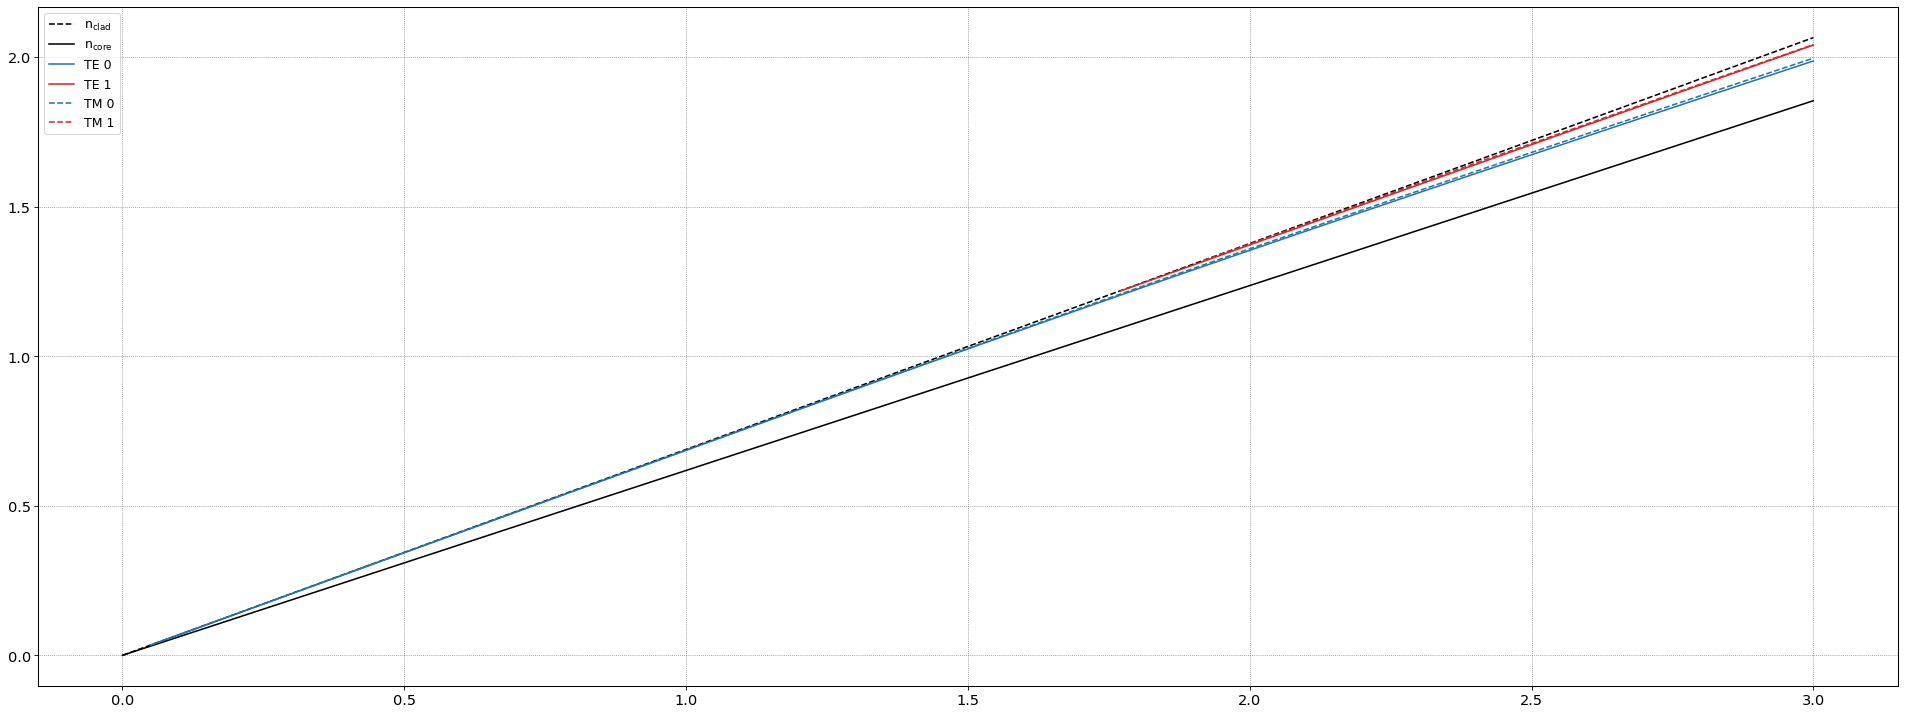

In [8]:
# visualize dispersion


fig,ax = plt.subplots(1,1,figsize=(32,12))

ax.plot(k,k/n_clad,'k--',label=r'n$_{\rm clad}$')
ax.plot(k,k/n_core,'k-',label=r'n$_{\rm core}$')

linestyles= ['-','--']
colors= ['C0','C3','C2','C4','C1']
pols = ['TE','TM']

for ωind,ω in enumerate([ω_odd,ω_even]):
    for mind in range(n_modes):
        mask = ω[:,mind]<(k/n_clad)
        ax.plot(k[mask],
                ω[mask,mind],
                label=pols[ωind] + f' {mind}',
                color=colors[mind],
                linestyle=linestyles[ωind]
               )

ax.legend(loc='upper left')

In [9]:
# plot settings
E = E_odd
F = 'E'
xlim = -2,2
ylim = -0.5,1.5
figsize=(14,5 + 3*n_modes)

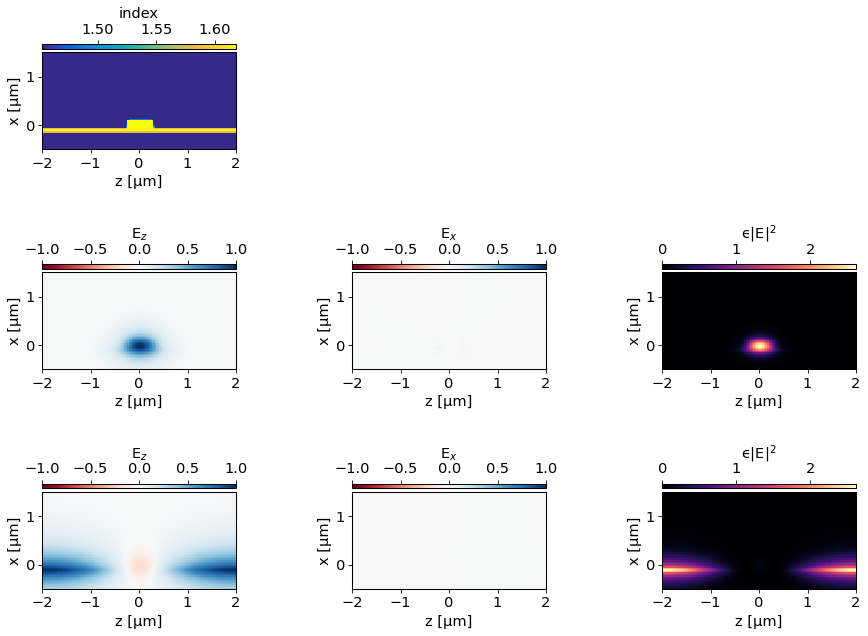

In [10]:
#### plot various computed fields for this instance ###
fig = plt.figure(figsize=figsize)
gs = GridSpec(n_modes+1,
              3,
              wspace=0.6,
              hspace=0.2,
             )

ax00 = fig.add_subplot(gs[0,0])

#ax02 = fig.add_subplot(gs[0,2])

# plot index as a function of space
p00 = ax00.pcolormesh(z,x,np.sqrt(ε),label='index')

# plot binary variable detecting core material
# p01 = ax01.pcolormesh(x,y,mat_core_mask.T,cmap=cm.Greys,label='core_mat')

# ax = [ax00,ax01,]
# p = [p00,p01,]
ax = [ax00,]
p = [p00,]

labels = ['index',
          'core_mat',
          'ϵ|E$_z$|$^2$',
         ]


for aind,a in enumerate(ax):
    if xlim:
        a.set_xlim(xlim)
    if ylim:
        a.set_ylim(ylim)
    a.set_aspect('equal')
    a.set_xlabel('z [μm]')
    a.set_ylabel('x [μm]')
    divider = make_axes_locatable(a)
    cax = divider.append_axes("top", size="5%", pad=0.05)
    cb = plt.colorbar(p[aind],
                 cax=cax,
                 orientation="horizontal",
                )
    cb.set_label(labels[aind])#,labelpad=-1)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

####################################################################


for mind in range(n_modes):
    ax =  [fig.add_subplot(gs[1+mind,0]),
            fig.add_subplot(gs[1+mind,1]),
            fig.add_subplot(gs[1+mind,2]),
          ]
    
    
#     F_norm = E[...,:,mind] / E[...,zind,:,mind].flatten()[np.argmax(np.abs(E[...,zind,:,mind]))]
    F_norm = E[:,:,:,mind] / E[:,:,:,mind].flatten()[np.argmax(np.abs(E[:,:,:,mind]))]
    eps_ei2 = ε[:,:] * ( np.abs(F_norm[:,:,0])**2 + np.abs(F_norm[:,:,1])**2 + np.abs(F_norm[:,:,2])**2 )
    labels = [
              'E$_{z}$',
              'E$_{x}$',
#               'E$_{z}$',
              'ϵ|E|$^2$',
    ]

#     if F == "H":
#         F_norm = H[...,:,mind] / H[...,:,mind].flatten()[np.argmax(np.abs(H[...,:,mind]))]
#         labels = [
#                   'H$_{x}$',
#                   'H$_{y}$',
#     #               'H$_{z}$',
#                    'ϵ|E|$^2$',
#                  ]
    
    # plot Fx, Fy, Fz and ϵ|E|^2 
    vmax = np.abs(F_norm.real).max()
    vmin = -1 * np.abs(F_norm.real).max() #E_norm.real.min()

    


    axind = 0 
    p10 = ax[axind].pcolormesh(z,
                          x,
                          F_norm[:,:,2].real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )

    axind = 1 
    p11 = ax[axind].pcolormesh(z,
                          x,
                          F_norm[:,:,0].real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )

#     axind = 2
#     p12 = ax[axind].pcolormesh(z,
#                           x,
#                           F_norm[:,:,axind].real,
#                           cmap=cm.RdBu,
#                           vmin=vmin,
#                           vmax=vmax,
#                          )
    
    axind = 2
    p12 = ax[axind].pcolormesh(z,x,eps_ei2,cmap=cm.magma)







    ## format and label plots

#     ax = [ax10,ax11,ax12,ax13,ax20,ax21,ax22]
    p = [p10,p11,p12]
    




    for aind,a in enumerate(ax):
        if xlim:
            a.set_xlim(xlim)
        if ylim:
            a.set_ylim(ylim)
        a.set_aspect('equal')
        a.set_xlabel('z [μm]')
        a.set_ylabel('x [μm]')
        divider = make_axes_locatable(a)
        cax = divider.append_axes("top", size="5%", pad=0.05)
        cb = plt.colorbar(p[aind],
                     cax=cax,
                     orientation="horizontal",
                    )
        cb.set_label(labels[aind])#,labelpad=-1)
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')

# print field energy integrals
res = ms.compute_field_energy()

In [12]:
D = ms.get_dfield(1)
U = ms.compute_field_energy()
U

D-energy-components:, 62, 1, 0.956286, 0.0424173, 0.00129632


[0.9999999999999959,
 0.9562863932380439,
 3.0109073438898184e-08,
 3.1847727095901365e-08,
 0.04241722807947247,
 0.0012962922757418596,
 2.444995425457366e-08]

In [14]:
ms.compute_energy_in_objects(ms.geometry)

0.9999999999999959

### try MEEP eigenfrequency solver with same geometry

In [ ]:
fcen = 2.0             # source center frequency                                                                                    

src = mp.Source(mp.ContinuousSource(fcen),
                component=mp.Ez,
                center=mp.Vector3())

sim = mp.Simulation(cell_size=mp.Vector3(sxy, sxy),
                    geometry=[c1, c2],
                    sources=[src],
                    resolution=40,
                    force_complex_fields=True,
                    symmetries=[mp.Mirror(mp.Y)],
                    boundary_layers=[mp.PML(dpml)])

## 3D

In [3]:
# parameters

# geometry and solver parameters

# define new parameters for angled sidewalls, partial etch, conformal deposited layers after wg etch,

θ = 20.  # sidewall angle in degrees, 0 = vertical
w_top = 0.45*u.um  # 0.2*u.um # top width of partially etched "core layer" in microns
t_core = 0.25*u.um  # full thickness of "core layer" in microns
t_etch = 0.17*u.um  # 0.15 # etch depth into "core layer" in microns
r_hole = 0.1*u.um

lam = 0.85*u.um  # free space wavelength in microns
dx_base = np.tan(np.deg2rad(θ)) * t_etch
nk = 10
mat_core = 'Alumina'
mat_clad = 'SiO2'

prop_ax = 1  # propagation axis 0=X, 1=Y, 2=Z
Xgrid = 4
Ygrid = 1
Zgrid = 4
n_modes = 4
res_x = 32
res_y = 32
res_z = 32
res = 32  # mp.Vector3(res_x,res_y,res_z)
do_func = None


# manually convert to unitless quantities for now
w_top = w_top.to(u.um).m
t_core = t_core.to(u.um).m
t_etch = t_etch.to(u.um).m
r_hole = r_hole.to(u.um).m
lam = lam.to(u.um).m
# ω = 1/lam # frequency in units of c

band_funcs = [mpb.fix_efield_phase, ]

# get phase and group indices for these materials at this wavelength
n_core = get_index(mat_core, lam)
ng_core = get_ng(mat_core, lam)
n_clad = get_index(mat_clad, lam)
ng_clad = get_ng(mat_clad, lam)
med_core = mp.Medium(index=n_core)
med_clad = mp.Medium(index=n_clad)

holes = [mp.Cylinder(center=mp.Vector3(0, 0, 0.6),
                     height=mp.inf,
                     radius=r_hole,
                     axis=mp.Vector3(1, 0, 0),
                     material=med_clad,
                     ),
         mp.Cylinder(center=mp.Vector3(0, 0, -0.6),
                     height=mp.inf,
                     radius=r_hole,
                     axis=mp.Vector3(1, 0, 0),
                     material=med_clad,
                     ),
         ]

In [9]:
# define geometry

# compute useful quantities with user parameters
nx = Xgrid * res_x
ny = Ygrid * res_y
nz = Zgrid * res_z

x = Xgrid * np.linspace(-1/2., 1/2., nx)
y = Ygrid * np.linspace(-1/2., 1/2., ny)
z = Zgrid * np.linspace(-1/2., 1/2., nz)

# k_points = [mp.Vector3(), mp.Vector3([0 if aind != prop_ax else 0.5 for aind in range(3)])]
# k_points = [mp.Vector3(), mp.Vector3(0,0.5,0)]
k_points = [mp.Vector3(), mp.Vector3(0,3.0,0)]
k_points = mp.interpolate(nk, k_points)
k = np.array([np.array(kk)[prop_ax] for kk in k_points])

# define geometry with design region
lat = mp.Lattice(size=mp.Vector3(Xgrid, Ygrid, Zgrid))
dx_base = np.tan(np.deg2rad(θ)) * t_etch

verts_core = [  mp.Vector3(t_etch/2,  0,  -w_top/2.),
                mp.Vector3(t_etch/2,  0,  w_top/2.),
                mp.Vector3(-t_etch/2,  0,  w_top/2+dx_base),
                mp.Vector3(-t_etch/2,  0,  -w_top/2-dx_base),
             ]

core = mp.Prism(verts_core,
                axis = mp.Vector3(0,1,0),
                height= 1.5 * Ygrid, #mp.inf,
                center= mp.Vector3(),
                material=med_core,
               )



if t_etch<t_core:   # partial etch
    slab = mp.Block(size=mp.Vector3(t_core-t_etch,
                                    mp.inf,
                                    mp.inf,),
                    center=mp.Vector3(-t_core/2,
                                      0,
                                      0,),
                    material=med_core,
                   )
    geom = [core,slab,] + holes
else:
    geom = [core,] + holes


In [14]:
# instantiate MPB solver
blackhole = StringIO()
with pipes(stdout=blackhole, stderr=STDOUT):
    ms = mpb.ModeSolver(geometry_lattice=lat,
                        geometry=[],
                        k_points=k_points,
                        resolution=res,
                        num_bands=n_modes,
                        default_material=med_clad)
    ms.geometry = geom
    ms.default_material = med_clad
    ms.init_params(mp.ODD_Z, False)

ε = ms.get_epsilon()

Working in 3 dimensions.
Grid size is 128 x 32 x 128.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (4, 0, 0)
     (0, 1, 0)
     (0, 0, 4)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (0.25, -0, 0)
     (-0, 1, -0)
     (0, -0, 0.25)
Geometric objects:
     prism, center = (0,0,0)
          height 1.5, axis (0,1,0), sidewall angle: 0 radians, 4 vertices:
          (0.085,-0.75,-0.225)
          (0.085,-0.75,0.225)
          (-0.085,-0.75,0.286875)
          (-0.085,-0.75,-0.286875)
     block, center = (-0.125,0,0)
          size (0.08,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0,0,0.6)
          radius 0.1, height 1e+20, axis (1, 0, 0)
     cylinder, center = (0,0,-0.6)
          radius 0.1, height 1e+20, axis (1, 0, 0)
Geometric object tree has depth 3 and 37 object nodes (vs. 4 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: zodd.
In

In [11]:
# instantiate MEEP simulation
sim = mp.Simulation(resolution=30,
                    cell_size=mp.Vector3(Xgrid,Ygrid,Zgrid),
                    geometry=geom)

sim.init_sim()

eps_data = sim.get_epsilon()

-----------
Initializing structure...
time for choose_chunkdivision = 1.09673e-05 s
Working in 3D dimensions.
Computational cell is 4 x 1 x 4 with resolution 30
     prism, center = (0,0,0)
          height 1.5, axis (0,1,0), sidewall angle: 0 radians, 4 vertices:
          (0.085,-0.75,-0.225)
          (0.085,-0.75,0.225)
          (-0.085,-0.75,0.286875)
          (-0.085,-0.75,-0.286875)
          dielectric constant epsilon diagonal = (2.61735,2.61735,2.61735)
     block, center = (-0.125,0,0)
          size (0.08,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.61735,2.61735,2.61735)
     cylinder, center = (0,0,0.6)
          radius 0.1, height 1e+20, axis (1, 0, 0)
          dielectric constant epsilon diagonal = (2.10987,2.10987,2.10987)
     cylinder, center = (0,0,-0.6)
          radius 0.1, height 1e+20, axis (1, 0, 0)
          dielectric constant epsilon diagonal = (2.10987,2.10987,2.10987)
subpixel-averaging is 4.6

In [15]:

d0 = np.array(ε).swapaxes(1,2).swapaxes(0,1)
nzpy = int((d0.shape[0]-d0.shape[2])/2)
# npad is a tuple of (n_before, n_after) for each dimension
npad = ((0, 0), (0, 0), (nzpy, nzpy))
d1 = np.pad(d0, pad_width=npad, mode='constant', constant_values=d0.min())



ipv.clear()
vs = ipv.volshow(d1,
                 extent=[[x.min(),x.max()],[y.min(),y.max()],[z.min(),z.max()]],
                )
ipv.xlim(x.min()/2,x.max()/2)
ipv.ylim(y.min(),y.max())
ipv.zlim(z.min()/2,z.max()/2)
ipv.pylab.view(120,30,2.0)
ipv.show()

/home/dodd/miniconda3/envs/mp_dev/lib/python3.6/site-packages/ipyvolume/serialize.py:92: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0] ** 2 + gradient[1] ** 2 + gradient[2] ** 2)


In [9]:
ipv.volshow(eps_data)


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

In [25]:
# import ipyvolume as ipv
# ipv.pylab.view(0,60,1.5) #(azimuth, elevation, distance)

ipv.pylab.view(0,0,2)

(0, 0, 2)

In [7]:
widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)

ColorPicker(value='blue', description='Pick a color')

In [29]:
fig = ipv.figure()
head = ipv.examples.head(draw=True, show=True, max_shape=256)

In [77]:
# mlab.init_notebook('x3d')
mlab.init_notebook()

Notebook initialized with ipy backend.


In [60]:
# instantiate ModeSolver and solve for a few modes

blackhole = StringIO()
with pipes(stdout=blackhole, stderr=STDOUT):
    ms = mpb.ModeSolver(geometry_lattice=lat,
                        geometry=[],
                        k_points=k_points,
                        resolution=res,
                        num_bands=n_modes,
                        default_material=med_clad)
    ms.geometry = geom
    ms.default_material = med_clad
    ms.init_params(mp.NO_PARITY, False)
    ms.run(*band_funcs)

ω = np.array(ms.all_freqs)
neff = k[:,np.newaxis] / (ω+.00001)
ε = ms.get_epsilon()
E = np.squeeze(np.stack([np.array(ms.get_efield(mind+1, bloch_phase=False)) for mind in range(n_modes)],axis=-1))

Working in 3 dimensions.
Grid size is 128 x 32 x 128.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (4, 0, 0)
     (0, 1, 0)
     (0, 0, 4)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (0.25, -0, 0)
     (-0, 1, -0)
     (0, -0, 0.25)
Geometric objects:
     prism, center = (0,5e+19,0)
          height 1e+20, axis (0,1,0), sidewall angle: 0 radians, 4 vertices:
          (0.085,0,-0.225)
          (0.085,0,0.225)
          (-0.085,0,0.286875)
          (-0.085,0,-0.286875)
     block, center = (-0.125,0,0)
          size (0.08,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 11 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
Initializing eigensolver data
Computing 4 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 128 x 32 x 128.
Solving for 4 bands at 

    iteration    5: trace = 0.6176161060440658 (0.0231714% change)
    iteration    6: trace = 0.6174164454483175 (0.0323328% change)
    iteration    7: trace = 0.6173564461283094 (0.00971828% change)
    iteration    8: trace = 0.6173120609340451 (0.00718982% change)
    iteration    9: trace = 0.6172755997814697 (0.00590661% change)
    iteration   10: trace = 0.617244027599964 (0.00511489% change)
    iteration   11: trace = 0.617215805372985 (0.0045724% change)
    iteration   12: trace = 0.6171900354709147 (0.00417527% change)
    iteration   13: trace = 0.6171661442755616 (0.00387104% change)
    iteration   14: trace = 0.6171437406508781 (0.00363015% change)
    iteration   15: trace = 0.6171225445631379 (0.00343461% change)
    iteration   16: trace = 0.6171023477228471 (0.0032728% change)
    iteration   17: trace = 0.617082990352904 (0.00313687% change)
    iteration   18: trace = 0.6170643467190806 (0.0030213% change)
    iteration   19: trace = 0.6170463156991759 (0.002922

    iteration   12: trace = 0.1208891265788786 (3.62835e-06% change)
Finished solving for bands 1 to 4 after 12 iterations.
freqs:, 4, 0, 0.818182, 0, 0.818182, 0.124793, 0.124858, 0.211516, 0.212102
elapsed time for k point: 11.878157138824463
Fixing e-field (band 1) phase by 1 + -1.92246e-05i; max ampl. = 0.186691
Fixing e-field (band 2) phase by 0.00933062 + -0.999956i; max ampl. = 0.18109
Fixing e-field (band 3) phase by -1 + -2.9847e-06i; max ampl. = 0.283625
Fixing e-field (band 4) phase by 0.827691 + 0.561183i; max ampl. = 0.294005
solve_kpoint (0,1.09091,0):
Solving for bands 1 to 4...
    iteration    1: trace = 0.0742726945168769 (0.0587629% change)
    iteration    2: trace = 0.07426987706048821 (0.00379347% change)
    iteration    3: trace = 0.07426947916541765 (0.000535744% change)
    iteration    4: trace = 0.07426349802262897 (0.00805362% change)
    iteration    5: trace = 0.07424674385261856 (0.022563% change)
    iteration    6: trace = 0.07424603115709828 (0.000959

    iteration   50: trace = 0.6362249447749937 (0.00854356% change)
    iteration   51: trace = 0.6361697299878172 (0.00867888% change)
    iteration   52: trace = 0.6361136662539044 (0.00881309% change)
    iteration   53: trace = 0.6360567455708055 (0.00894859% change)
    iteration   54: trace = 0.6359989410486461 (0.00908836% change)
    iteration   55: trace = 0.6359402030788972 (0.00923597% change)
    iteration   56: trace = 0.6358804550937277 (0.00939566% change)
    iteration   57: trace = 0.6358195885982684 (0.00957246% change)
    iteration   58: trace = 0.6357574569983937 (0.00977237% change)
    iteration   59: trace = 0.6356938675186663 (0.0100027% change)
    iteration   60: trace = 0.635628570153646 (0.0102724% change)
    iteration   61: trace = 0.6355612420171095 (0.0105929% change)
    iteration   62: trace = 0.6354914644538557 (0.0109795% change)
    iteration   63: trace = 0.6354186884584709 (0.0114526% change)
    iteration   64: trace = 0.6353421804650297 (0.0120

    iteration   11: trace = 0.07425091772070352 (0.000596189% change)
    iteration   12: trace = 0.07422210216482295 (0.0388159% change)
    iteration   13: trace = 0.0742004050982305 (0.0292369% change)
    iteration   14: trace = 0.07418807724263768 (0.0166157% change)
    iteration   15: trace = 0.07418481305487626 (0.00439998% change)
    iteration   16: trace = 0.07418318310199584 (0.00219718% change)
    iteration   17: trace = 0.07418099731653019 (0.00294651% change)
    iteration   18: trace = 0.07417307793881708 (0.0106763% change)
    iteration   19: trace = 0.07414624014239468 (0.0361892% change)
    iteration   20: trace = 0.07412083163713051 (0.034274% change)
    iteration   21: trace = 0.07411852511419839 (0.00311189% change)
    iteration   22: trace = 0.07411547192259099 (0.00411942% change)
    iteration   23: trace = 0.0741044768283186 (0.0148362% change)
    iteration   24: trace = 0.07408967732007077 (0.0199731% change)
    iteration   25: trace = 0.07408515164166

    iteration   53: trace = 0.4470737956083166 (0.00126611% change)
    iteration   54: trace = 0.447068433914557 (0.00119929% change)
    iteration   55: trace = 0.4470637408833571 (0.00104974% change)
    iteration   56: trace = 0.4470597297458193 (0.000897222% change)
    iteration   57: trace = 0.4470559851110991 (0.000837617% change)
    iteration   58: trace = 0.447051979236615 (0.000896061% change)
    iteration   59: trace = 0.4470474296974418 (0.00101768% change)
    iteration   60: trace = 0.4470426480996306 (0.0010696% change)
    iteration   61: trace = 0.447038372324582 (0.000956463% change)
    iteration   62: trace = 0.4470349963835807 (0.000755182% change)
    iteration   63: trace = 0.4470323343090505 (0.000595498% change)
    iteration   64: trace = 0.4470299909145993 (0.000524213% change)
    iteration   65: trace = 0.4470276179732557 (0.000530825% change)
    iteration   66: trace = 0.4470249929837157 (0.000587211% change)
    iteration   67: trace = 0.4470220746864

    iteration   82: trace = 0.1986419380631972 (0.00335089% change)
    iteration   83: trace = 0.1986310193344792 (0.00549684% change)
    iteration   84: trace = 0.1986046734418169 (0.0132646% change)
    iteration   85: trace = 0.1985827692575101 (0.0110296% change)
    iteration   86: trace = 0.1985753618995071 (0.00373018% change)
    iteration   87: trace = 0.1985730480183508 (0.00116525% change)
    iteration   88: trace = 0.198572507386655 (0.000272259% change)
    iteration   89: trace = 0.1985722993081557 (0.000104787% change)
    iteration   90: trace = 0.1985721532701357 (7.3544e-05% change)
    iteration   91: trace = 0.1985717711991362 (0.000192409% change)
    iteration   92: trace = 0.1985709519754784 (0.000412559% change)
    iteration   93: trace = 0.1985696506017086 (0.000655372% change)
    iteration   94: trace = 0.1985689240281565 (0.000365904% change)
    iteration   95: trace = 0.1985686201345604 (0.000153042% change)
    iteration   96: trace = 0.19856852835617

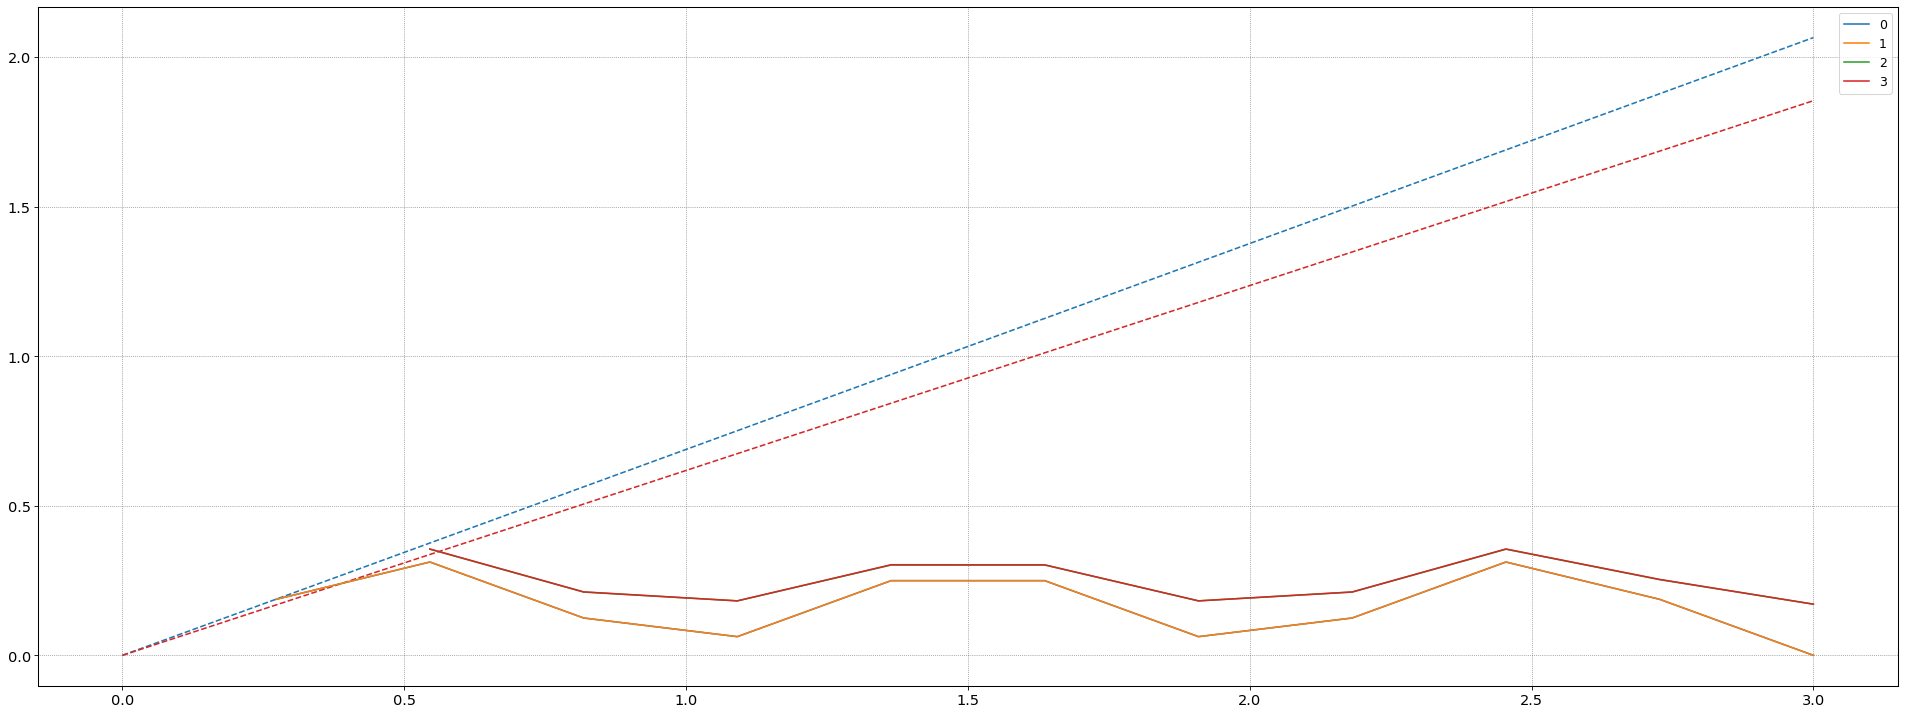

In [61]:
# visualize dispersion


fig,ax = plt.subplots(1,1,figsize=(32,12))

ax.plot(k,k/n_clad,'C0--')
ax.plot(k,k/n_core,'C3--')

for mind in range(n_modes):
    mask = ω[:,mind]<(k/n_clad)
    ax.plot(k[mask],ω[mask,mind],label=f'{mind}')

ax.legend()

In [35]:
E = np.squeeze(np.stack([np.array(ms.get_efield(mind+1, bloch_phase=False)) for mind in range(n_modes)],axis=-1))

In [56]:
# plot settings
F = 'E'
xlim = -2,2
ylim = -0.5,1.5
figsize=(14,5 + 3*n_modes)

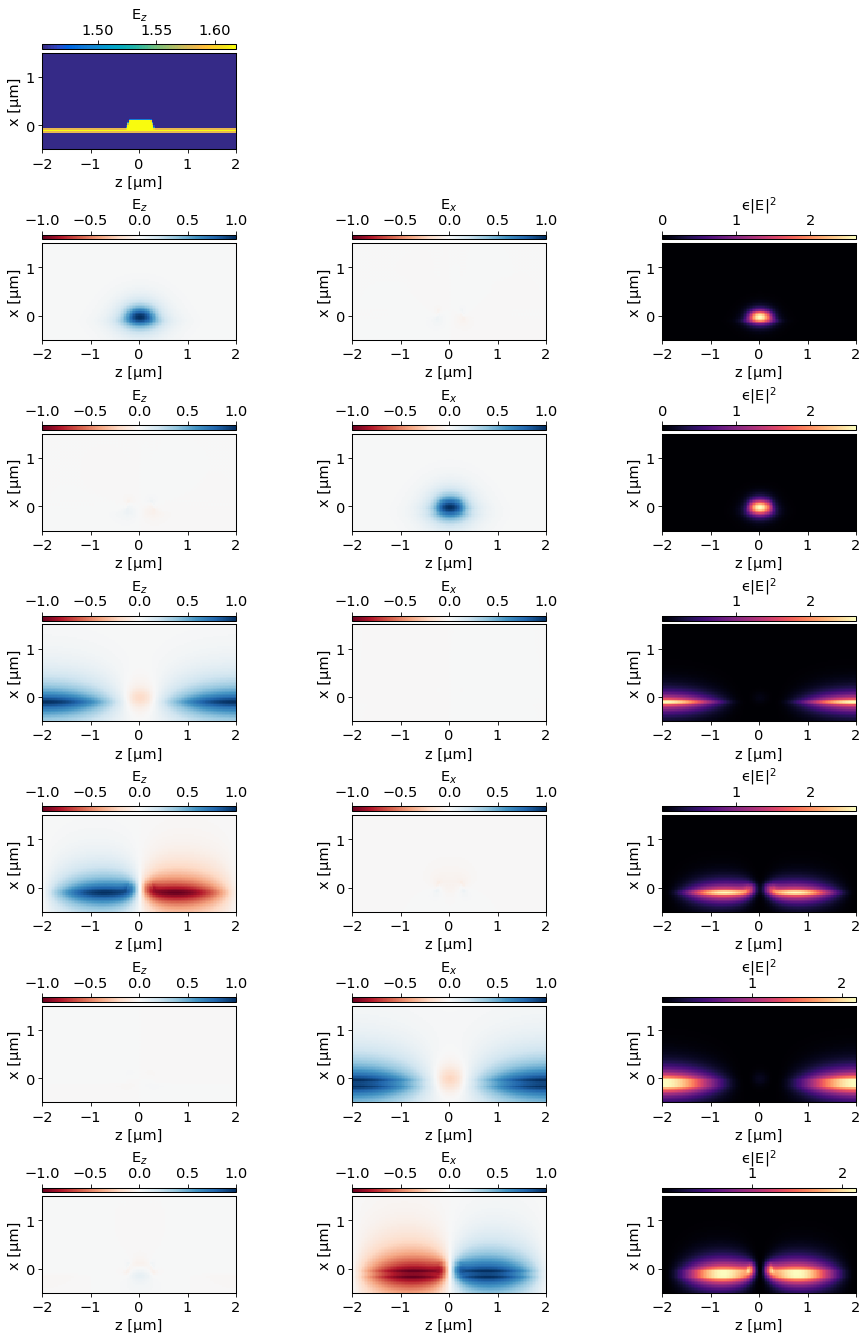

In [57]:
#### plot various computed fields for this instance ###
fig = plt.figure(figsize=figsize)
gs = GridSpec(n_modes+1,
              3,
              wspace=0.6,
              hspace=0.2,
             )

ax00 = fig.add_subplot(gs[0,0])

#ax02 = fig.add_subplot(gs[0,2])

# plot index as a function of space
p00 = ax00.pcolormesh(z,x,np.sqrt(ε),label='index')

# plot binary variable detecting core material
# p01 = ax01.pcolormesh(x,y,mat_core_mask.T,cmap=cm.Greys,label='core_mat')

# ax = [ax00,ax01,]
# p = [p00,p01,]
ax = [ax00,]
p = [p00,]

# labels = ['index',
#           'core_mat',
#           'ϵ|E$_x$|$^2$',
#           'E$_{x}$',
#           'E$_{y}$',
#           'E$_{z}$',
#           'H$_{x}$',
#           'H$_{y}$',
#           'H$_{z}$',
#          ]


for aind,a in enumerate(ax):
    if xlim:
        a.set_xlim(xlim)
    if ylim:
        a.set_ylim(ylim)
    a.set_aspect('equal')
    a.set_xlabel('z [μm]')
    a.set_ylabel('x [μm]')
    divider = make_axes_locatable(a)
    cax = divider.append_axes("top", size="5%", pad=0.05)
    cb = plt.colorbar(p[aind],
                 cax=cax,
                 orientation="horizontal",
                )
    cb.set_label(labels[aind])#,labelpad=-1)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

####################################################################


for mind in range(n_modes):
    ax =  [fig.add_subplot(gs[1+mind,0]),
            fig.add_subplot(gs[1+mind,1]),
            fig.add_subplot(gs[1+mind,2]),
          ]
    
    
#     F_norm = E[...,:,mind] / E[...,zind,:,mind].flatten()[np.argmax(np.abs(E[...,zind,:,mind]))]
    F_norm = E[:,:,:,mind] / E[:,:,:,mind].flatten()[np.argmax(np.abs(E[:,:,:,mind]))]
    eps_ei2 = ε[:,:] * ( np.abs(F_norm[:,:,0])**2 + np.abs(F_norm[:,:,1])**2 + np.abs(F_norm[:,:,2])**2 )
    labels = [
              'E$_{z}$',
              'E$_{x}$',
#               'E$_{z}$',
              'ϵ|E|$^2$',
    ]

#     if F == "H":
#         F_norm = H[...,:,mind] / H[...,:,mind].flatten()[np.argmax(np.abs(H[...,:,mind]))]
#         labels = [
#                   'H$_{x}$',
#                   'H$_{y}$',
#     #               'H$_{z}$',
#                    'ϵ|E|$^2$',
#                  ]
    
    # plot Fx, Fy, Fz and ϵ|E|^2 
    vmax = np.abs(F_norm.real).max()
    vmin = -1 * np.abs(F_norm.real).max() #E_norm.real.min()

    


    axind = 0 
    p10 = ax[axind].pcolormesh(z,
                          x,
                          F_norm[:,:,2].real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )

    axind = 1 
    p11 = ax[axind].pcolormesh(z,
                          x,
                          F_norm[:,:,0].real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )

#     axind = 2
#     p12 = ax[axind].pcolormesh(z,
#                           x,
#                           F_norm[:,:,axind].real,
#                           cmap=cm.RdBu,
#                           vmin=vmin,
#                           vmax=vmax,
#                          )
    
    axind = 2
    p12 = ax[axind].pcolormesh(z,x,eps_ei2,cmap=cm.magma)







    ## format and label plots

#     ax = [ax10,ax11,ax12,ax13,ax20,ax21,ax22]
    p = [p10,p11,p12]
    




    for aind,a in enumerate(ax):
        if xlim:
            a.set_xlim(xlim)
        if ylim:
            a.set_ylim(ylim)
        a.set_aspect('equal')
        a.set_xlabel('z [μm]')
        a.set_ylabel('x [μm]')
        divider = make_axes_locatable(a)
        cax = divider.append_axes("top", size="5%", pad=0.05)
        cb = plt.colorbar(p[aind],
                     cax=cax,
                     orientation="horizontal",
                    )
        cb.set_label(labels[aind])#,labelpad=-1)
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')

# print field energy integrals
res = ms.compute_field_energy()

In [63]:
# instantiate solver and run
ε.shape

(128, 32, 128)